## Bonus

- Apply decision tree for the sentimental analysis on the same task.
- Tuned hyper-parameters (max_depth, loss_criterion) to maximize the accuracy.
- Select and plot the best model. Compare this model with models in our assignment.
- Compute the top-most mutual information for the best model.

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import math
from sklearn.metrics import confusion_matrix

## Decision Trees for Sentimental Analysis

In [58]:
def split_data(data):
    np.random.seed(21)  # Set Seed

    x_dset = data[:, :173]
    y_dset = data[:, 173]

    # Split Datasets
    x_train, x_left, y_train, y_left = train_test_split(x_dset, y_dset, test_size=0.3)
    x_val, x_test, y_val, y_test = train_test_split(x_left, y_left, test_size=0.5)
    return {'x_train': x_train, 'x_val': x_val, 'x_test': x_test,
            'y_train': y_train, 'y_val': y_val, 'y_test': y_test}

In [59]:
def get_accuracy(C):
    """ Compute accuracy given Numpy array confusion matrix C. Returns a floating point value """
    return round(np.sum(np.diag(C)) / np.sum(C), 4)


def select_model(data: dict):

    # Initialize Hyper-parameters
    max_depths = [2 ** i for i in range(1, 6)]
    criterions = ['gini', 'entropy', 'log_loss']
    record = [[], [], []]

    # Training and Record Accuracy
    for max_depth in max_depths:
        i = 0
        for criterion in criterions:
            new_model = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion)
            new_model.fit(data['x_train'], data['y_train'])
            y_prediction = new_model.predict(data['x_val'])
            confusion_matrx = confusion_matrix(data['y_val'], y_prediction)
            val_accuracy = get_accuracy(confusion_matrx)

            record[i].append(val_accuracy)
            print(
                f"The validation accuracy for model max_depth {max_depth} and criterion {criterion} is {val_accuracy}")
            i = i + 1

    # Select the model with the highest accuracy
    highest_accuracy = max(max(record[i]) for i in range(0, 3))
    highest_model = None
    for i in range(0, 3):
        for j in range(0, 5):
            if record[i][j] == highest_accuracy:
                highest_model = (max_depths[j], criterions[i])
                break
        if highest_model is not None:
            break
    print(
        f"""The model that reaches the highest accuracy has max_depth {highest_model[0]} and criterion {highest_model[1]}
            The corresponding accuracy is {highest_accuracy}""")

    # Find the best model and get test_accuracy
    final_model = DecisionTreeClassifier(max_depth=highest_model[0], criterion=highest_model[1])
    final_model.fit(data['x_train'], data['y_train'])
    y_prediction = final_model.predict(data['x_test'])
    confusion_matrx = confusion_matrix(data['y_test'], y_prediction)
    test_accuracy = get_accuracy(confusion_matrx)
    print(f"Our best model has test accuracy {test_accuracy}")

    # Plot
    plt.plot(max_depths, record[0], c='r', label='gini')
    plt.scatter(max_depths, record[0], c='r', label='gini')
    plt.plot(max_depths, record[1], c='g', label='entropy')
    plt.scatter(max_depths, record[1], c='g', label='entropy')
    plt.plot(max_depths, record[2], c='b', label='log_loss')
    plt.scatter(max_depths, record[2], c='b', label='log_loss')
    plt.title('val accuracy vs. max_depth')
    plt.xlabel('max_depths')
    plt.ylabel('val accuracy')
    plt.legend()
    plt.show()

    return final_model

In [60]:
def entropy(events_num: list) -> float:
    all_en = []
    for event_num in events_num:
        event_prob = event_num / (sum(events_num))
        single = (event_prob * math.log(event_prob, 2)) if event_prob > 0 else 0
        all_en.append(single)
    return -sum(all_en)


def compute_mutual_information(lst: list) -> float:
    # Compute H(Y)
    numbers = []
    for i in range(len(lst[0])):
        numbers.append(sum([branch[i] for branch in lst]))
    h_y = entropy(numbers)

    # Compute H(Y | X)
    h_value = []
    h_prob = []
    for j in range(len(lst)):
        h_value.append(entropy(lst[j]))
        h_prob.append(sum(lst[j]) / sum(numbers))

    h_y_under_x = sum(h_value[k] * h_prob[k] for k in range(0, len(lst)))

    return round(h_y - h_y_under_x, 5)

The validation accuracy for model max_depth 2 and criterion gini is 0.3277
The validation accuracy for model max_depth 2 and criterion entropy is 0.3277
The validation accuracy for model max_depth 2 and criterion log_loss is 0.3277
The validation accuracy for model max_depth 4 and criterion gini is 0.3823
The validation accuracy for model max_depth 4 and criterion entropy is 0.3878
The validation accuracy for model max_depth 4 and criterion log_loss is 0.3878
The validation accuracy for model max_depth 8 and criterion gini is 0.4155
The validation accuracy for model max_depth 8 and criterion entropy is 0.4178
The validation accuracy for model max_depth 8 and criterion log_loss is 0.4177
The validation accuracy for model max_depth 16 and criterion gini is 0.394
The validation accuracy for model max_depth 16 and criterion entropy is 0.3908
The validation accuracy for model max_depth 16 and criterion log_loss is 0.388
The validation accuracy for model max_depth 32 and criterion gini is 0.

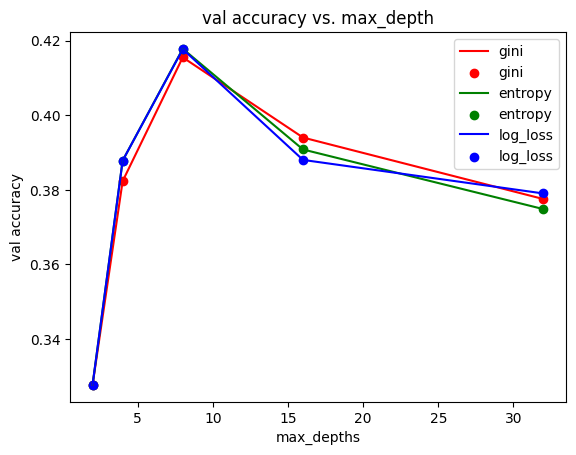

Information Gain for the topmost split: 0.05215


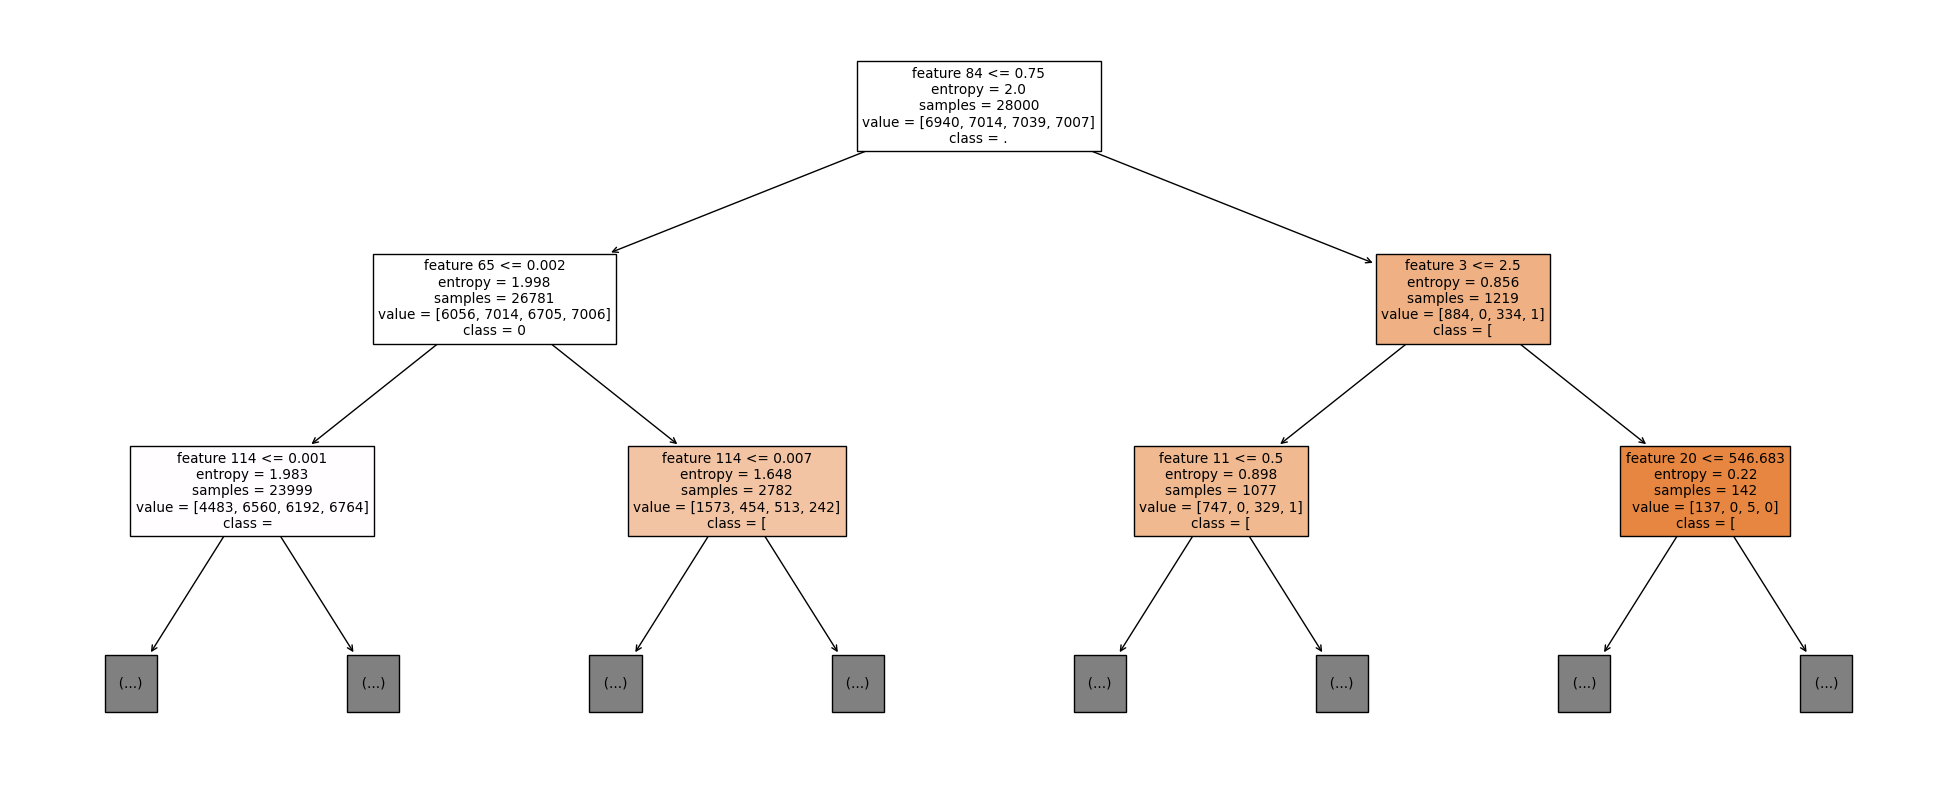

In [61]:
if __name__ == '__main__':
    data = np.load("feats.npz")['arr_0']
    data = split_data(data)
    model = select_model(data)
    features = []
    for i in range(173):
        features.append(f'feature {i + 1}')
    features = np.asarray(features)
    fig = plt.figure(figsize=(25, 10))
    tree.plot_tree(model, filled=True, max_depth=2, class_names=str(model.classes_), feature_names=features)
    print(f"Information Gain for the topmost split: {compute_mutual_information([[6056, 7014, 6705, 7006], [884, 0, 334, 1]])}")

## Conclusion

Our best accuracy is 0.4178 (val_accuracy), this is lower than the accuracy of our best classifier(AdaBoostClassifier) in the assignment, which is 0.4753